IPSuite uses [DVC](https://dvc.org) to manage its files and workflows. In this part we will fit different GAP models to our data and compare them.

In [1]:
import ipsuite as ips

2023-12-21 10:09:31,376 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [2]:
with ips.Project() as project:
    data = ips.AddData(file="KCl1650K.extxyz", lines_to_read=100)
    test_data = ips.configuration_selection.UniformEnergeticSelection(
        data=data, n_configurations=10, name="test_data"
    )
    # we have now given the Nodes a "name" attribute to uniquly identify them
    train_data = ips.configuration_selection.RandomSelection(
        data=data,
        n_configurations=5,
        exclude_configurations=test_data.exclude_configurations,
        name="train_data",
    )
    model = ips.models.GAP(data=train_data, OPENBLAS_NUM_THREADS="1")
    prediction = ips.analysis.Prediction(model=model, data=test_data)
    analyse = ips.analysis.PredictionMetrics(data=prediction)
project.run()


Running DVC command: 'stage add --name PredictionMetrics --force ...': 100%|██████████████████████████████████| 6/6 [00:00<00:00,  6.57it/s]
Running DVC command: 'repro'


2023-12-21 10:09:34,025 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!
2023-12-21 10:09:34,249 (DEBUG): Selecting from 100 configurations.
2023-12-21 10:09:34,249 (WARNING): Running search for 10 to max 100
2023-12-21 10:09:36,253 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!
2023-12-21 10:09:36,630 (DEBUG): Selecting from 100 configurations.
2023-12-21 10:09:38,568 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!
2023-12-21 10:09:38,714 (INFO): ---- Writing the GAP input file ----
2023-12-21 10:09:38,847 (INFO): --- Training model ---
2023-12-21 10:09:42,319 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


100%|█████████████████████████████████| 10/10 [00:01<00:00,  6.18it/s]


2023-12-21 10:09:46,305 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


We can now invesitage our Model.

In [3]:
analyse = analyse.from_rev()
print(analyse.energy)
print(analyse.forces)

{'rmse': 1.3976198541271143, 'mse': 1.9533412566502963, 'mae': 0.727601655072067, 'max': 3.9621493491576985, 'lp4': 0.399737742123205, 'rrmse': 0.03637335096028674}
{'rmse': 77.05158325562425, 'mse': 5936.946482198397, 'mae': 62.38155166414371, 'max': 243.87692659743027, 'lp4': 0.5565018190284512, 'rrmse': 0.2042344261884382}


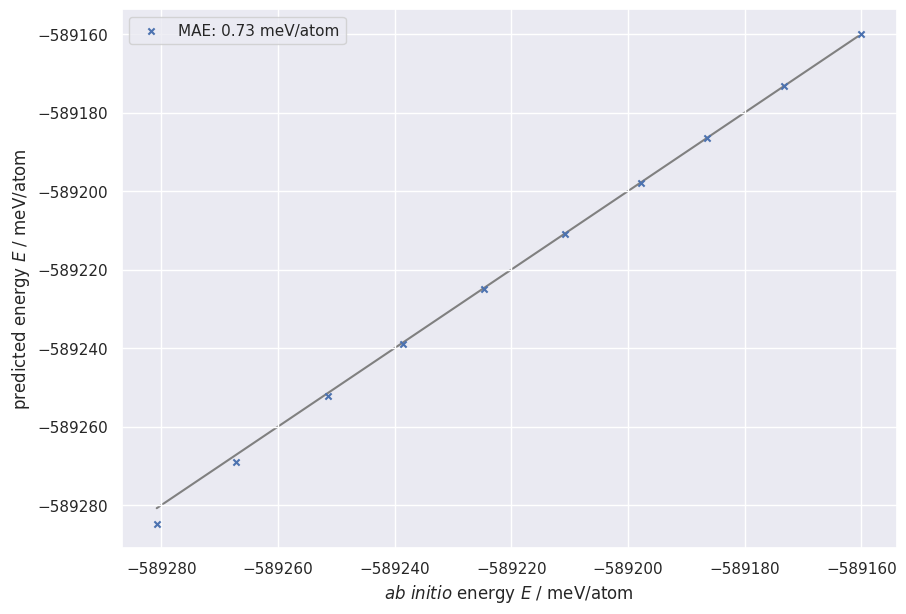

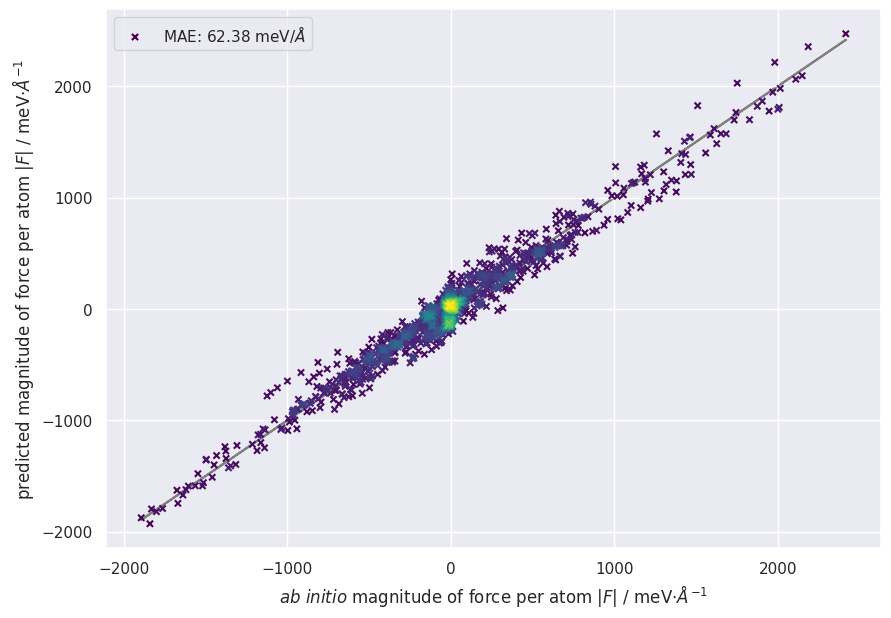

In [4]:
analyse.get_plots()

We can use `dvc dag --mermaid` to display the graph that was created for us:

[![](https://mermaid.ink/img/pako:eNpdkdFKwzAUhl-lnOtt2Lm20AtBnFdbQfRC0IiE5tQG0mSkp7o69u6edV1Xe3fy_X8OH8kBcqcQUiiM-8lL6SnYPgsryDIO3wXcK7WWJAV8XOjyRK00bY1PHpXOSTs7ym853zyYMI5uNgvc0779XajvfNRYcSPbZjyZEY2Y9gtfNZXTOOaYvNT2U_33SU4B1jTl4Xx-112cgmQw7UE4iPUgGpx6sBwspo2kB6spiGEGFfpKasXPexA2CNizxAoFpDwqLGRjSICwR642O9bHR6XJeUjJNzgD2ZB7aW1-OZ87ay2_vKwgLaSpme6kfXPuesZuR3b-1u53j3-xQ6q3?type=png)](https://mermaid.live/edit#pako:eNpdkdFKwzAUhl-lnOtt2Lm20AtBnFdbQfRC0IiE5tQG0mSkp7o69u6edV1Xe3fy_X8OH8kBcqcQUiiM-8lL6SnYPgsryDIO3wXcK7WWJAV8XOjyRK00bY1PHpXOSTs7ym853zyYMI5uNgvc0779XajvfNRYcSPbZjyZEY2Y9gtfNZXTOOaYvNT2U_33SU4B1jTl4Xx-112cgmQw7UE4iPUgGpx6sBwspo2kB6spiGEGFfpKasXPexA2CNizxAoFpDwqLGRjSICwR642O9bHR6XJeUjJNzgD2ZB7aW1-OZ87ay2_vKwgLaSpme6kfXPuesZuR3b-1u53j3-xQ6q3)

If we want to train our model on a different amount of training data, we can modify the `train_data` Node.
This will only rerun nodes that are dependent on the `train_data` Node. In our case, this means that the `test_data` Node won't be affect and we can ensure, that all models are evaluated on the same test data.

To compare `experiments` we need to create them first.

In [5]:
with project.create_experiment(name="baseline") as exp1 :
    # this will store the current experiment with the name "baseline"
    pass

with project.create_experiment() as exp2:
    train_data.n_configurations = 10

with project.create_experiment() as exp3:
    train_data.n_configurations = 3

project.run_exp()

Running DVC command: 'stage add --name PredictionMetrics --force ...': 100%|██████████████████████████████████| 6/6 [00:00<00:00,  7.97it/s]
Running DVC command: 'stage add --name PredictionMetrics --force ...': 100%|██████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s]
Running DVC command: 'stage add --name PredictionMetrics --force ...': 100%|██████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s]
Running DVC command: 'exp run --run-all --jobs 1'


Now let's have a look at the results. We can load the Experiments using `exp.load` followed by `exp.nodes['node-name']` or  via `Node.from_rev(rev=<name>)`.

In [6]:
for exp in [exp3, exp1, exp2]:
    exp.load()
    print(f"'{exp.name}': {exp['train_data'].n_configurations = }")

'dirty-debt': exp['train_data'].n_configurations = 3
'baseline': exp['train_data'].n_configurations = 5
'sleek-ease': exp['train_data'].n_configurations = 10


In [7]:
print(analyse.from_rev(rev=exp3.name).energy)
print(analyse.from_rev(rev=exp1.name).energy)
print(analyse.from_rev(rev=exp2.name).energy)

{'rmse': 0.9288776761621848, 'mse': 0.8628137372724606, 'mae': 0.5359225455205887, 'max': 2.3958834855584428, 'lp4': 0.2481278526332662, 'rrmse': 0.024174237089186215}


{'rmse': 1.9700851370309989, 'mse': 3.8812354471504498, 'mae': 1.1318164533004165, 'max': 5.201957696233876, 'lp4': 0.5325268503409623, 'rrmse': 0.05127188047541554}
{'rmse': 0.8222520875118782, 'mse': 0.6760984954176413, 'mae': 0.4330883580376394, 'max': 2.314887194894254, 'lp4': 0.2339523735429742, 'rrmse': 0.021399283695477462}


You can also use the CLI `dvc exp show` to compare your experiments.


To make these Experiments persistent and store them inside your GIT repository there are multiple options:
- you can use `dvc exp branch <exp> <branch>` and push that branch to your remote.
- you can use `dvc exp apply <exp>` and commit the experiment and push to your remote.

To store all experiments, you can make temporary branches using `dvc exp branch` and then consecutively merge them into the branch you want them to be stored in.

In [8]:
# We want to remove the experiments here, so we can rerun the Notebook.
!dvc exp remove -A

Removed experiments: 'baseline', 'sleek-ease' and 'dirty-debt'        
